<font size="7"><i><b>Pre-process</b></i></font>


<font size="5"><i><b>Import Data</b></i></font>

In [467]:
import pandas as pd
df_raw = pd.read_csv('/Users/alyssa/Desktop/case.study/AirQualityUCI.csv')
# For further visualisation purpose, we split the Date column into year, month, and day. We also change the Time column to hour.
df_raw[['Day', 'Month', 'Year']] = df_raw['Date'].str.split('/', expand=True)
df_raw['Hour'] = df_raw['Time'].str.split(':').str[0]
df_raw.drop(columns=['Date', 'Time'], inplace=True)
df_raw.insert(0, 'Year', df_raw.pop('Year'))
df_raw.insert(1, 'Month', df_raw.pop('Month'))
df_raw.insert(2, 'Day', df_raw.pop('Day'))
df_raw.insert(3, 'Hour', df_raw.pop('Hour'))

<font size="5"><i><b>Data Clean</b></i></font>

In [468]:
df_raw.replace(-200, float('nan'), inplace=True)
# Upon a brief look at the dataset and its missing values, we delete the last 2 columns and 114 rows as they are empty.
print(df_raw.isnull().sum())
df_raw = df_raw.iloc[:-114, :-2]
# Then we delete rows with 3 missing values or more, since for at least three missing values in one data entry, imputation would introduce considerable noise to the model.
null_per_row = df_raw.isnull().sum(axis=1)
remove = null_per_row > 2
df_removed = df_raw[~remove]
# After initial clean, there is no duplicated row.
print(df_removed.duplicated().sum())
# There are still some missing values in the dataset, which will be imputed in next step (EDA).
print(df_removed.isnull().sum())
df_removed.reset_index(drop=True, inplace=True)

Year              114
Month             114
Day               114
Hour              114
CO(GT)           1797
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          480
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 480
RH                480
AH                480
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64
0
Year                0
Month               0
Day                 0
Hour                0
CO(GT)            452
PT08.S1(CO)         0
NMHC(GT)         6545
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)            36
PT08.S3(NOx)        0
NO2(GT)            39
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
dtype: int64


<font size="7"><i><b>Exploratory Data Analysis</i></b></font>

<font size="5"><i><b>Step1: Data Cleaning and Preprocessing</b></i></font>

In [ ]:
'''
From the above result, it can be observed that CO(GT), NMHC(GT), C6H6(GT), NOx(GT) and NO2(GT) still have missing values, thus, we choose these 5 columns to conduct EDA. 
In this step we mainly focus on imputing missing values and deleting outliers - since we have finished the initial cleaning. 
We use KNN model but not simple mean filling as it can improve the accuracy of filled values and the quality of the data. 
''' 

# KNN Imputation
from sklearn.impute import KNNImputer
time_columns = df_removed[['Year', 'Month', 'Day', 'Hour']]
df_removed_numeric = df_removed.drop(columns=['Year', 'Month', 'Day', 'Hour'])

imputer = KNNImputer()
df_imputed_numeric = pd.DataFrame(imputer.fit_transform(df_removed_numeric), columns=df_removed_numeric.columns)
df_imputed = pd.concat([time_columns, df_imputed_numeric], axis=1)

In [470]:
# Identifying Outliers
from scipy.stats import zscore

outlier = pd.DataFrame()
for column in df_imputed_numeric.columns:
    z = zscore(df_imputed_numeric[column])
    outlier_index = df_imputed_numeric.index[z > 3]
    outlier = pd.concat([outlier, df_imputed.loc[outlier_index]])
outlier = outlier.drop_duplicates()
print(outlier.shape[0])

df_clean = df_imputed.drop(outlier.index)
df_clean_numeric = df_imputed_numeric.drop(outlier.index)

df_clean.reset_index(drop=True, inplace=True)
df_clean_numeric.reset_index(drop=True, inplace=True)

367


<font size="5"><i><b>Step2: Summary Statistics</i></b></font>

In [333]:
df_EDA = df_clean[['Year','Month','Day','CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)','NO2(GT)']]
df_EDA_numeric = df_clean[['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)','NO2(GT)']]
df_EDA_numeric.describe()

,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT)
count,7065.000000,7065.000000,7065.000000,7065.000000,7065.000000
mean,2.005699,231.403765,9.727785,222.869498,109.582307
std,1.206783,173.512505,6.343704,171.945692,44.151114
min,0.100000,11.000000,0.300000,2.000000,2.000000
25%,1.100000,101.600000,4.700000,95.000000,77.000000
50%,1.760000,175.800000,8.400000,172.000000,107.000000
75%,2.700000,309.400000,13.700000,303.000000,137.000000
max,6.400000,809.400000,32.600000,858.000000,254.000000


<font size="5"><i><b>Step3: Data Visualisations</i></b></font>

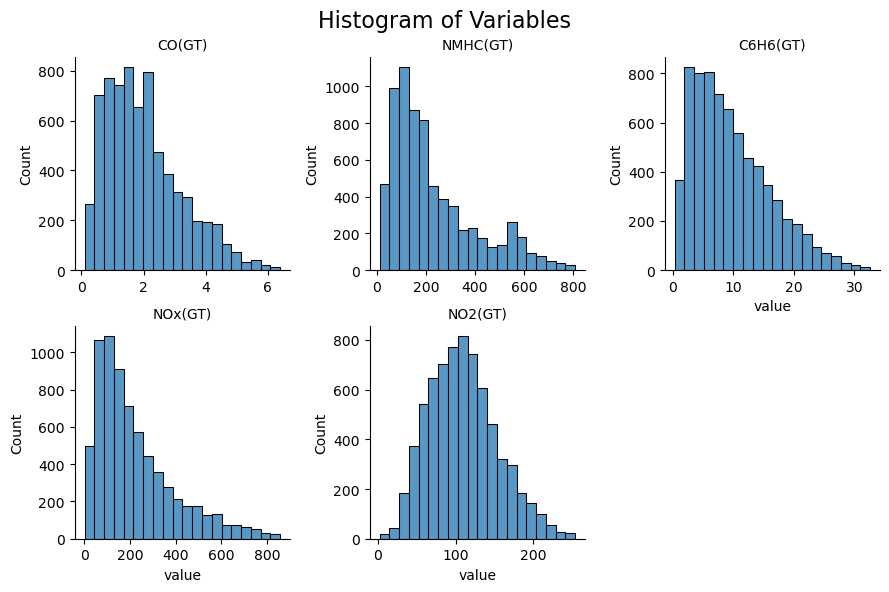

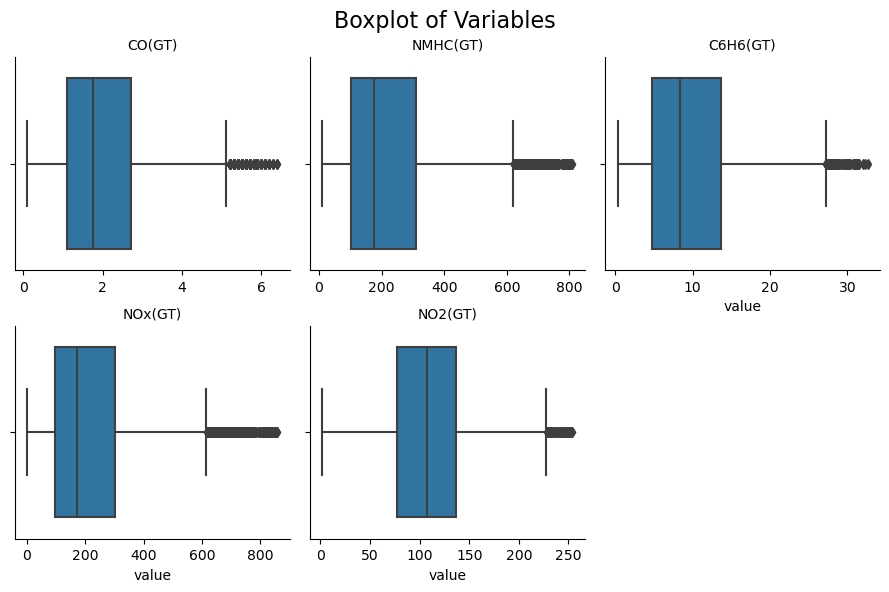

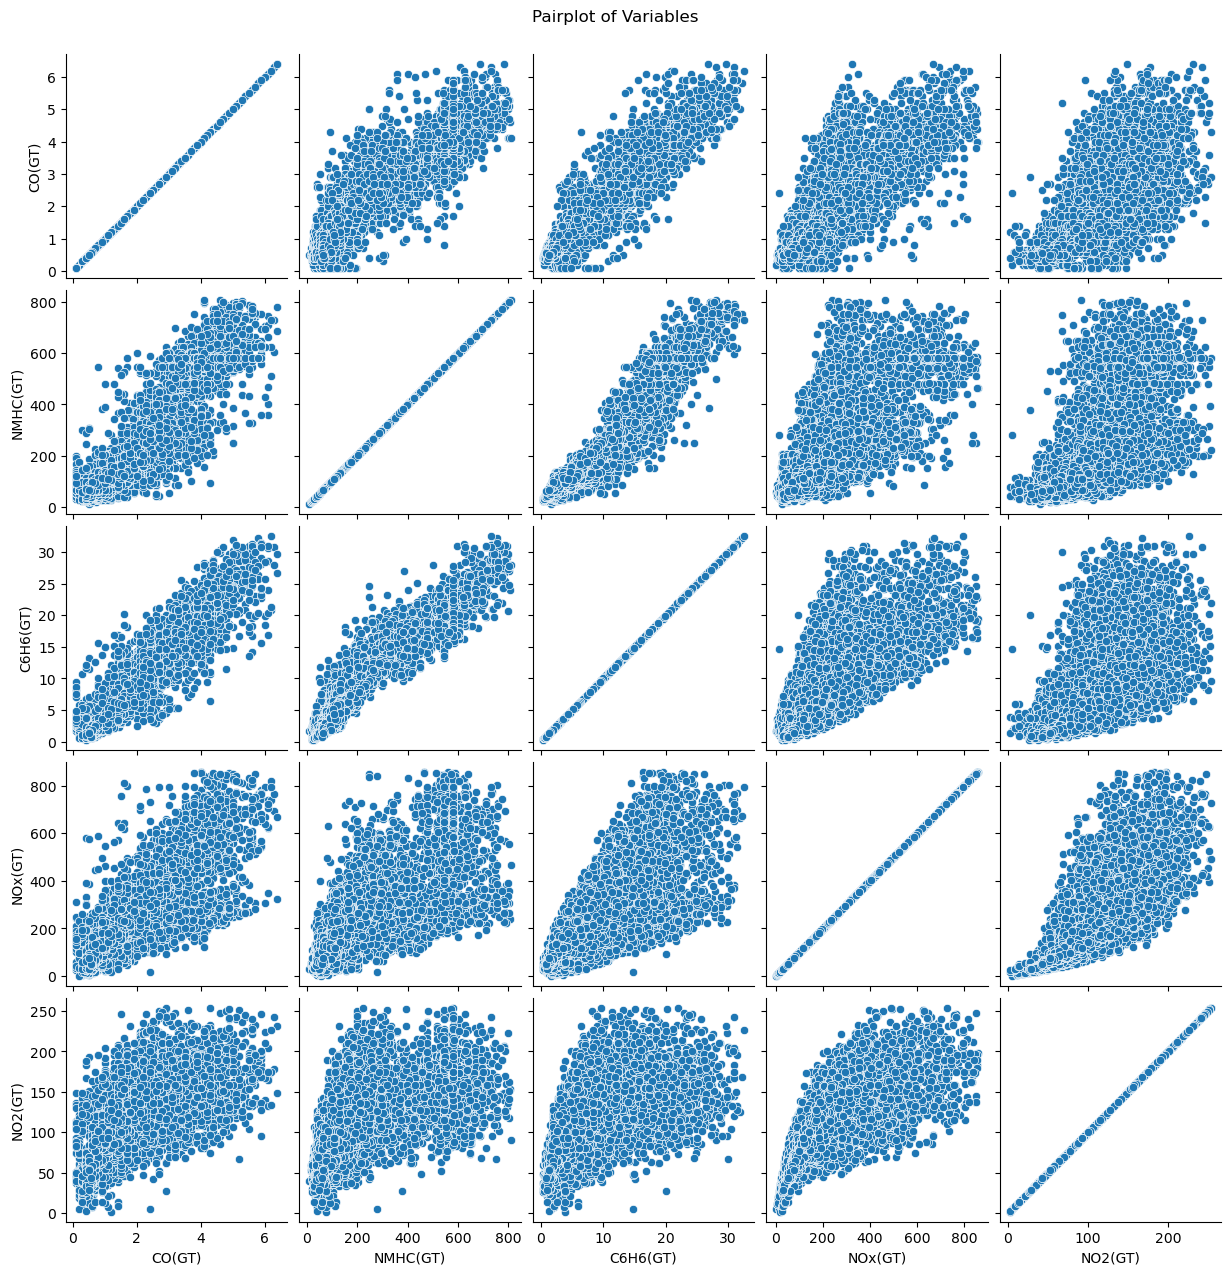

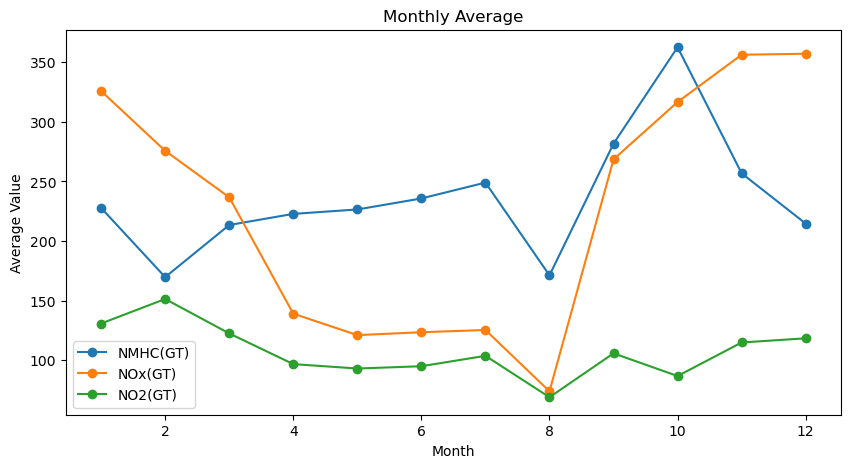

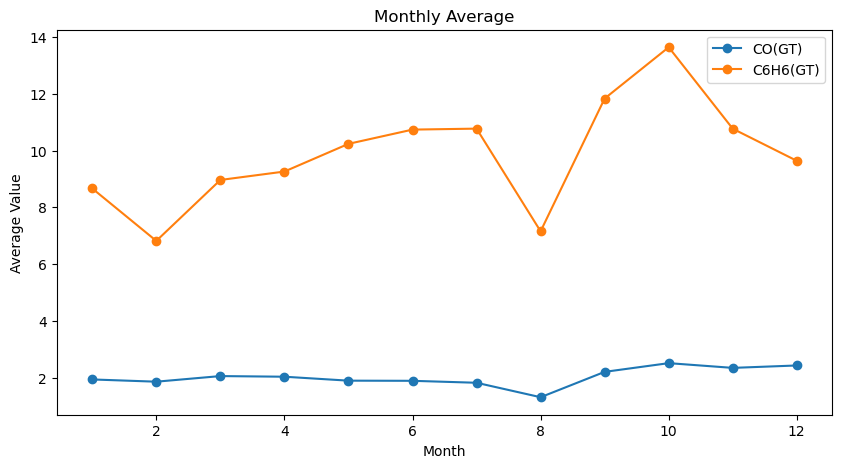

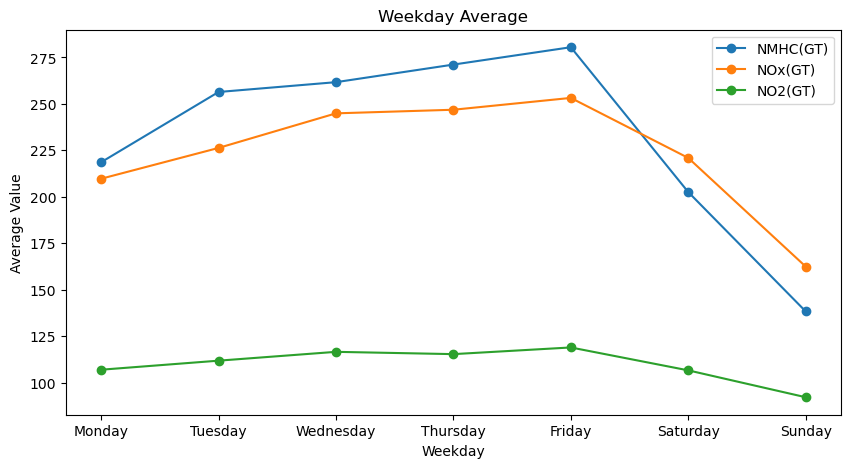

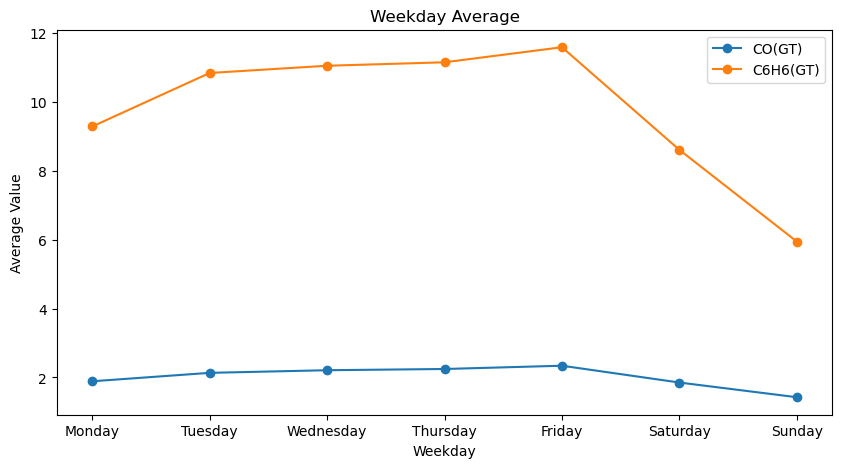

In [530]:
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated", category=FutureWarning)
warnings.filterwarnings("ignore", message="Using the boxplot function without specifying `order` is likely to produce an incorrect plot.")

# Histogram
g_1 = sb.FacetGrid(df_EDA_numeric.melt(), col='variable', col_wrap=3, sharex=False, sharey=False)
g_1.map(sb.histplot, 'value', bins=20)
g_1.set_titles('{col_name}')
plt.subplots_adjust(top=0.9)
g_1.fig.suptitle('Histogram of Variables', fontsize=16)
plt.show()

# Boxplot
g_2 = sb.FacetGrid(df_EDA_numeric.melt(), col='variable', col_wrap=3, sharex=False, sharey=False)
g_2.map(sb.boxplot, 'value')
g_2.set_titles('{col_name}')
plt.subplots_adjust(top=0.9)
g_2.fig.suptitle('Boxplot of Variables', fontsize=16)
plt.show()

# Scatter Plot
sb.pairplot(df_EDA_numeric, diag_kind=None)
plt.suptitle('Pairplot of Variables', y=1.02)
plt.show()

# Monthly Plot
df_EDA = df_EDA.apply(pd.to_numeric, errors='coerce')

monthly_average = df_EDA.groupby(['Month'], as_index=False).mean()
plt.figure(figsize=(10, 5))
for column in ['NMHC(GT)', 'NOx(GT)', 'NO2(GT)']:
    plt.plot(monthly_average['Month'], monthly_average[column], marker='o', label=column)
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.title('Monthly Average')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for column in ['CO(GT)', 'C6H6(GT)']:
    plt.plot(monthly_average['Month'], monthly_average[column], marker='o', label=column)
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.title('Monthly Average')
plt.legend()
plt.show()

# Weekday Plot
weekday_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df_EDA['Weekday'] = pd.to_datetime(df_EDA[['Year', 'Month', 'Day']]).dt.dayofweek.map(weekday_mapping)

weekday_average = df_EDA.groupby('Weekday').mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 5))
for column in ['NMHC(GT)', 'NOx(GT)', 'NO2(GT)']:
    plt.plot(weekday_average.index, weekday_average[column], marker='o', label=column)
plt.xlabel('Weekday')
plt.ylabel('Average Value')
plt.title('Weekday Average')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for column in ['CO(GT)', 'C6H6(GT)']:
    plt.plot(weekday_average.index, weekday_average[column], marker='o', label=column)
plt.xlabel('Weekday')
plt.ylabel('Average Value')
plt.title('Weekday Average')
plt.legend()
plt.show()

<font size="5"><i><b>Step4: Correlation Analysis</i></b></font>

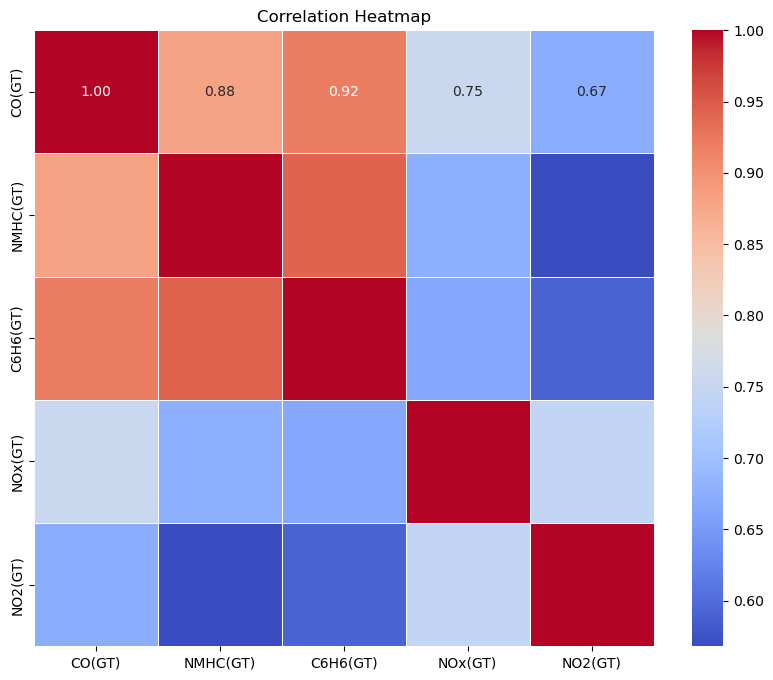

In [514]:
correlation_matrix = df_EDA_numeric.corr()

plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [515]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = df_EDA_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(df_EDA_numeric.values, i) for i in range(len(df_EDA_numeric.columns))]

print(vif_data)

   Variable        VIF
0    CO(GT)  32.691494
1  NMHC(GT)  26.333432
2  C6H6(GT)  46.004528
3   NOx(GT)   7.693483
4   NO2(GT)   8.447229


<font size="5"><i><b>Step5: Summary and Reporting</i></b></font>

Step1:  In this step, we imputed missing value by KNN method, and removed outliers with z-score >3.  
Step2:  From the summary statistic, we can observe that due to different scales, CO(GT) and C6H6(GT) have lower values than other 3, thus, in following steps, we plot them separately for better analysis.  
Step3: From the histograms, the distributions of NO2(GT) is approximately normal, while other 4 are obviously right-skewed. Box plots give the same result as histograms - with the exception of NO2(GT), all variables have left-leaning medians and boxes. The scatter plots can indicate positive relationships between each variable - as they tend to increase together. However, the points are not very dense, indicating that this is not a very strong relationship. From monthly plots, all pollution decreased in August, but increased significantly in October (except NO2). In addition, we can see from Weekday Plots that pollution is significantly lower on weekends than on weekdays.  
Step4:  As we find positive relationships in step3, we conduct further analysis in correlation and multicollinearity. From the heatmap, we can see CO(GT), NMHC(GT), C6H6(GT) have high correlations with each other, this can also be observed in VIF - these 3 variables have VIF >10.


<font size="7"><i><b>Split Data</i></b></font>

In [ ]:
# As we need to predict all 13 columns, we generate 13 dataframes (each with 1 response variable and 13 features), they are stored in a list.
# Then we split the data into train and test datasets, with proportion 8:2.
# In this step, we only use 'Month' from all time variables, as per discussed, months have some effect on pollution, while years, days and hours have less.

from sklearn.model_selection import train_test_split

X_train_list = []
X_test_list = []
Y_train_list = []
Y_test_list = []

for response_var in df_clean_numeric.columns:
    X = df_clean.drop(columns=[response_var,'Hour','Year','Day'])
    Y = df_clean_numeric[[response_var]]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=666)

    X_train_list.append(X_train)
    X_test_list.append(X_test)
    Y_train_list.append(Y_train)
    Y_test_list.append(Y_test)

In [ ]:
# Since the scale of the variables is different, we will standardise them first.

from sklearn.preprocessing import StandardScaler

scalers = []
X_train_scaled_list = []
X_test_scaled_list = []

for i in range(len(X_train_list)):
    scaler = StandardScaler()
    scalers.append(scaler)

    X_train_scaled = scaler.fit_transform(X_train_list[i])
    X_test_scaled = scaler.transform(X_test_list[i])

    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_list[i].columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_list[i].columns)
    
    X_train_scaled_list.append(X_train_scaled_df)
    X_test_scaled_list.append(X_test_scaled_df)

In [611]:
import joblib
for i, scaler in enumerate(scalers):
    joblib.dump(scaler, f'scaler_{i}.joblib')

<font size="7"><i><b>Model Training</i></b></font>

In [ ]:
# In terms of Machine Learning Model, our candidates are: Multiple Linear Regression (MLR), Support Vector Machine (SVM), and Random Forest. In terms of Deep Learning Model, our candidate is Multi-layer Perceptron (MLP). Appropriateness of each model will be evaluated before the model is fitted.

<font size="5"><i><b>Multiple Linear Regression</b></i></font>

In [ ]:
'''
Model Assumptions
    Linearity: The relationship between the variables is linear.
    Errors: The errors should be independent and normally distributed.
    Homoscedasticity: The variance of the errors should be constant.
    Multicollinearity: The independent variables should not be highly correlated with each other.
Outperform
    When the Relationship is Linear
Advantages
    Interpretability: MLR provides coefficients for each predictor, thus, it is easier to interpret.
Disadvantages
    Sensitivity to Assumptions: MLR's performance is sensitive to the violation of model assumptions.
'''

In [483]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

LINEAR_MODELS = []
LINEAR_SELECTED_FEATURES = []

for i in range(len(X_train_scaled_list)):
    linear_model = LinearRegression()
    selector = RFE(estimator=linear_model, n_features_to_select=13, step=1)
    selector = selector.fit(X_train_scaled_list[i], Y_train_list[i])
    selected_features = X_train_scaled_list[i].columns[selector.support_]
    LINEAR_SELECTED_FEATURES.append(selected_features)
    
    linear_model.fit(X_train_scaled_list[i][selected_features], Y_train_list[i])
    LINEAR_MODELS.append(linear_model)

# When fitting multiple linear models, we try to select predictors first. However, after changing number of selected predictors, MSE will increase if we delete any predictor, thus we keep all predictors, that is, n_features_to_select=13.

<font size="5"><i><b>Support Vector Machine</b></i></font>

In [ ]:
'''
Model Assumptions
    SVM does not make strong assumptions about the distribution of data. However, SVM performance can be affected by the choice of kernel and hyperparameters.
Outperform
    Binary Classification: SVM is particularly effective for binary classification tasks.
Advantages
    Flexibility: SVM allows for both linear and non-linear decision boundary within data through the use of different kernels.
Disadvantages
    Computational Complexity: It does not perform well when the data set is too large otherwise it would be very computational expensive.
'''

In [ ]:
# In SVM model. we fit models with different kernels and keep them until the model selection step - to see which one performs better.
    
from sklearn.svm import SVR

SVM_LINEAR_MODELS = []
SVM_POLY_MODELS = []
SVM_RBF_MODELS = []
SVM_SIGMOID_MODELS = []

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for i in range(len(X_train_scaled_list)):
    for kernel in kernels:
        svm_model = SVR(kernel=kernel)
        Y_train_flat = Y_train_list[i].values.ravel()
        svm_model.fit(X_train_scaled_list[i], Y_train_flat)
        
        if kernel == 'linear':
            SVM_LINEAR_MODELS.append(svm_model)
        elif kernel == 'poly':
            SVM_POLY_MODELS.append(svm_model)
        elif kernel == 'rbf':
            SVM_RBF_MODELS.append(svm_model)
        elif kernel == 'sigmoid':
            SVM_SIGMOID_MODELS.append(svm_model)

<font size="5"><i><b>Random Forest</b></i></font>

In [ ]:
'''
Model Assumptions
    Random Forest does not make strong assumptions about the distribution of data.
Outperform
    Random Forest performs well on large datasets with many features and instances.
Advantages 
    Accuracy: Random Forest tends to achieve high accuracy in classification and regression tasks.
Disadvantages
    Interpretability: Random Forest models can be challenging to interpret due to the ensemble nature of the model.
'''

In [562]:
# In random forest, we simply set number of tress to be 500 as it might not affect too much on our model, and we try two maximum features, 0.2 and square root.

from sklearn.ensemble import RandomForestRegressor

RF_LINEAR_MODELS = []
RF_SQRT_MODELS = []

for i in range(len(X_train_scaled_list)):
    rf_linear_model = RandomForestRegressor(n_estimators=500, max_features=0.2)
    Y_train_flat = Y_train_list[i].values.ravel()
    rf_linear_model.fit(X_train_scaled_list[i], Y_train_flat)
    RF_LINEAR_MODELS.append(rf_linear_model)

    rf_sqrt_model = RandomForestRegressor(n_estimators=500, max_features='sqrt')
    rf_sqrt_model.fit(X_train_scaled_list[i], Y_train_flat)
    RF_SQRT_MODELS.append(rf_sqrt_model)

<font size="5"><i><b>Multi-layer Perceptron</b></i></font>

In [ ]:
'''
Model Assumption
    MLP does not make strong assumptions about the distribution of data.
Outperform
    Large Datasets: MLP can handle large datasets with many features, given sufficient computational resources.
Advantages
    Feature Learning: MLP can automatically learn useful representations from raw data, reducing the need for manual feature engineering.
Disadvantages
    Overfitting: MLP models are prone to overfitting, especially when the model architecture is too complex or the dataset is small.
'''

In [ ]:
'''
In this step, we tune parameters when fitting models. We mainly focus on hidden layer size and alpha. We define 9 parameter combinations, that are, 
    {'hidden_layer_sizes': (50,), 'alpha': 0.0001},
    {'hidden_layer_sizes': (50,), 'alpha': 0.001},
    {'hidden_layer_sizes': (50,), 'alpha': 0.01},
    {'hidden_layer_sizes': (100,), 'alpha': 0.0001},
    {'hidden_layer_sizes': (100,), 'alpha': 0.001},
    {'hidden_layer_sizes': (100,), 'alpha': 0.01},
    {'hidden_layer_sizes': (50, 50), 'alpha': 0.0001},
    {'hidden_layer_sizes': (50, 50), 'alpha': 0.001},
    {'hidden_layer_sizes': (50, 50), 'alpha': 0.01}
We fit them separately to see whether the optimisation converges when the maximum iterations is reached. We first name the models as MLP_MODELS_1 to 9, after the selection is made, we will rename the selected model.
Due to limited computing power, we set maximum iterations to be 1000.
'''

In [546]:
from sklearn.neural_network import MLPRegressor
MLP_MODELS_1 = []

for i in range(len(X_train_scaled_list)):
    mlp_model = MLPRegressor(max_iter=1000, learning_rate='adaptive', learning_rate_init=0.001, hidden_layer_sizes=(50,), alpha=0.0001)
    Y_train_flat = Y_train_list[i].values.ravel()
    mlp_model.fit(X_train_scaled_list[i], Y_train_flat)
    MLP_MODELS_1.append(mlp_model)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_netwo

In [557]:
MLP_MODELS_2 = []

for i in range(len(X_train_scaled_list)):
    mlp_model = MLPRegressor(max_iter=1000, learning_rate='adaptive', learning_rate_init=0.001, hidden_layer_sizes=(50,), alpha=0.001)
    Y_train_flat = Y_train_list[i].values.ravel()
    mlp_model.fit(X_train_scaled_list[i], Y_train_flat)
    MLP_MODELS_2.append(mlp_model)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_netwo

In [564]:
MLP_MODELS_3 = []

for i in range(len(X_train_scaled_list)):
    mlp_model = MLPRegressor(max_iter=1000, learning_rate='adaptive', learning_rate_init=0.001, hidden_layer_sizes=(50,), alpha=0.01)
    Y_train_flat = Y_train_list[i].values.ravel()
    mlp_model.fit(X_train_scaled_list[i], Y_train_flat)
    MLP_MODELS_3.append(mlp_model)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_netwo

In [543]:
MLP_MODELS_4 = []

for i in range(len(X_train_scaled_list)):
    mlp_model = MLPRegressor(max_iter=1000, learning_rate='adaptive', learning_rate_init=0.001, hidden_layer_sizes=(100,), alpha=0.0001)
    Y_train_flat = Y_train_list[i].values.ravel()
    mlp_model.fit(X_train_scaled_list[i], Y_train_flat)
    MLP_MODELS_4.append(mlp_model)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_netwo

In [553]:
MLP_MODELS_5 = []

for i in range(len(X_train_scaled_list)):
    mlp_model = MLPRegressor(max_iter=1000, learning_rate='adaptive', learning_rate_init=0.001, hidden_layer_sizes=(100,), alpha=0.001)
    Y_train_flat = Y_train_list[i].values.ravel()
    mlp_model.fit(X_train_scaled_list[i], Y_train_flat)
    MLP_MODELS_5.append(mlp_model)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_netwo

In [556]:
MLP_MODELS_6 = []

for i in range(len(X_train_scaled_list)):
    mlp_model = MLPRegressor(max_iter=1000, learning_rate='adaptive', learning_rate_init=0.001, hidden_layer_sizes=(100,), alpha=0.01)
    Y_train_flat = Y_train_list[i].values.ravel()
    mlp_model.fit(X_train_scaled_list[i], Y_train_flat)
    MLP_MODELS_6.append(mlp_model)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_netwo

In [555]:
MLP_MODELS_7 = []

for i in range(len(X_train_scaled_list)):
    mlp_model = MLPRegressor(max_iter=1000, learning_rate='adaptive', learning_rate_init=0.001, hidden_layer_sizes=(50,50), alpha=0.0001)
    Y_train_flat = Y_train_list[i].values.ravel()
    mlp_model.fit(X_train_scaled_list[i], Y_train_flat)
    MLP_MODELS_7.append(mlp_model)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [554]:
MLP_MODELS_8 = []

for i in range(len(X_train_scaled_list)):
    mlp_model = MLPRegressor(max_iter=1000, learning_rate='adaptive', learning_rate_init=0.001, hidden_layer_sizes=(50,50), alpha=0.001)
    Y_train_flat = Y_train_list[i].values.ravel()
    mlp_model.fit(X_train_scaled_list[i], Y_train_flat)
    MLP_MODELS_8.append(mlp_model)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [541]:
MLP_MODELS_9 = []

for i in range(len(X_train_scaled_list)):
    mlp_model = MLPRegressor(max_iter=1000, learning_rate='adaptive', learning_rate_init=0.001, hidden_layer_sizes=(50,50), alpha=0.01)
    Y_train_flat = Y_train_list[i].values.ravel()
    mlp_model.fit(X_train_scaled_list[i], Y_train_flat)
    MLP_MODELS_9.append(mlp_model)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [558]:
'''
From the above result, we can see that models 1-6 have more times of misconvergences compared with models 7-9. Thus, we can conclude hidden layer size (50,50) is more suitable for our dataset and model, which means there are two hidden layers in the neural network, with the first hidden layer containing 50 neurons and the second hidden layer also containing 50 neurons.
Here we rename models 7-9 for better understanding.
'''
MLP_MODELS_A0001 = MLP_MODELS_7
MLP_MODELS_A001 = MLP_MODELS_8
MLP_MODELS_A01 = MLP_MODELS_9

<font size="7"><i><b>Model Selection</i></b></font>

In [ ]:
'''
Selection Criteria
    RMSE (Root Mean Squared Error): RMSE provides a clear indication of how well the model fits the data. Lower RMSE values indicate better model performance in terms of prediction accuracy.
    Adjusted R^2: R^2 measures the proportion of the variance in the dependent variable that is predictable from the independent variables. Adjusted R^2 provides a balance between model fit and complexity as it adjusts for the number of predictors in the model and penalises the addition of unnecessary variables. 
    BIC: BIC balances the goodness of fit of the model with the number of parameters, penalising complex models to avoid overfitting. Lower BIC values indicate better model fit while considering model complexity.
'''

In [563]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

MODELS_list = [LINEAR_MODELS, SVM_LINEAR_MODELS, SVM_POLY_MODELS, SVM_RBF_MODELS, SVM_SIGMOID_MODELS, RF_LINEAR_MODELS, RF_SQRT_MODELS, MLP_MODELS_A0001, MLP_MODELS_A001, MLP_MODELS_A01]
model_types = ["LINEAR_MODELS", "SVM_LINEAR_MODELS", "SVM_POLY_MODELS", "SVM_RBF_MODELS", "SVM_SIGMOID_MODELS", "RF_LINEAR_MODELS", "RF_SQRT_MODELS", "MLP_MODELS_A0001", "MLP_MODELS_A001", "MLP_MODELS_A01"]
results_list = []

for models, model_type in zip(MODELS_list, model_types):
    model_results = []

    for i, (model, response_var) in enumerate(zip(models, Y_train_list)):
        Y_pred_test = model.predict(X_test_scaled_list[i])
        Y_pred_train = model.predict(X_train_scaled_list[i])

        RMSE_test = np.sqrt(mean_squared_error(Y_test_list[i], Y_pred_test))
        RMSE_train = np.sqrt(mean_squared_error(Y_train_list[i], Y_pred_train))
        MSE_test = mean_squared_error(Y_test_list[i], Y_pred_test)

        n = len(Y_test_list[i])
        p = X_test_scaled_list[i].shape[1]
        BIC = n * np.log(MSE_test) + p * np.log(n)
        
        r2 = r2_score(Y_test_list[i], Y_pred_test)
        adjr2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
        model_results.append({'Response Variable': response_var.columns[0], 'Test RMSE': RMSE_test, 'Train RMSE': RMSE_train, 'Adjusted R2': adjr2, 'BIC': BIC})

    results_list.append(pd.DataFrame(model_results))

for i, df in enumerate(results_list):
    print(f"Results for {model_types[i]}:")
    print(df)


overall_results = []
for i, df in enumerate(results_list):
    overall_results.append({
        'Model Type': model_types[i],
        'Test RMSE': df['Test RMSE'].mean(),
        'Train RMSE': df['Train RMSE'].mean(),
        'Adjusted R2': df['Adjusted R2'].mean(),
        'BIC': df['BIC'].mean()
    })

overall_df = pd.DataFrame(overall_results)

print("Average Results:")
print(overall_df)

Results for LINEAR_MODELS:
   Response Variable   Test RMSE  Train RMSE  Adjusted R2           BIC
0             CO(GT)    0.388490    0.370330     0.901459  -2577.652490
1        PT08.S1(CO)   66.889824   67.954175     0.887063  11972.105523
2           NMHC(GT)   50.566662   48.145395     0.916021  11181.519708
3           C6H6(GT)    0.698522    0.659076     0.987897   -919.642972
4      PT08.S2(NMHC)   23.896646   22.873732     0.989957   9063.278999
5            NOx(GT)   62.032287   60.663712     0.880034  11759.048177
6       PT08.S3(NOx)   76.510368   75.419167     0.881650  12351.861716
7            NO2(GT)   19.646142   20.029132     0.805298   8509.786806
8       PT08.S4(NO2)   67.103245   65.959923     0.957345  11981.107903
9        PT08.S5(O3)  138.350343  131.836832     0.860611  14025.879359
10                 T    2.420220    2.308902     0.927268   2592.078903
11                RH    5.980057    5.851031     0.884801   5148.398787
12                AH    0.110916    0

In [ ]:
# From the above result, we can choose MLP with hidden layer size (50,50) and alpha=0.01 as our optimal model, as it has second-lowest Test MSE, highest adjusted R square, and lowest BIC. 
# Among other 3 types of models, random forest performs well, however, the Test RMSE is nearly three times the Train RMSE, implying the potential problem of overfitting. Maximum features in this situation have little to none effect on our model, as we can see the two RF models do not differ a lot in each indice.
# It is worth mentioning MLR performs better than any SVM model, this may be caused by data size and relationships between variables. SVM Model with linear kernel performs best among all kernel types, while sigmoid kernel is obviously a worst choice.

<font size="7"><i><b>Summary</i></b></font>

Limitations and future improvements:  
MLP computational complexity:  The running time of MLP models is significantly longer than other models, and further tuning of parameters may improve this issue.
KNN Imputation:  For NMHC(GT), we impute almost 90% of the data as they are missing. Although we use KNN to decrease the noise brought by imputation, it is still a problem. Besides, we use the default K (5), we could use cross validation to determine K for better imputation.  
Data Split: We split the data by assigning 80% data to training set and 20% to the testing set. However, if we change the weights we assign to the training and testing set, the error rate may change. For example, if we give 90% weight for training data set and the rest 10% for test data set, the training error rate may have two different changes. For one, the training error rate may decrease a lot since there are more data for learning so the model will fit very well. However, it also causes the problem of overfitting and the test error rate might be higher. For the other, the training error rate may increase because more addition of the data may introduce a significant amount of noise or mislabeled data making the model struggle with distinguish the correct and incorrect ones.  
Random Forest Overfitting: Although according to our selection criteria, MLP will be chosen regardless of RF's overfit, we still need further evidence to conclude it is overfitted.

In [ ]:
from joblib import dump
for i, model in enumerate(MLP_MODELS_A01):
    with open(f'model_{i}.joblib', 'wb') as f:
        dump(model, f)